In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches 
from skimage.feature import Cascade
from skimage.transform import resize
from skimage import color
from skimage import data

import plotly.express as px # pip install plotly
import plotly.graph_objects as go

In [49]:
# define funtions
def show_image(image):
    plt.imshow(image)
    plt.set_cmap('gray')
    plt.axis('off')
    plt.show()
    
def show_detected_face(image,detected):
    plt.imshow(image)
    img_desc = plt.gca()
    plt.axis('off')
    for patch in detected:
        start_x = patch['c']
        start_y = patch['r']
        
        img_desc.add_patch(patches.Rectangle(
            (start_x,start_y),
            patch['width'],
            patch['height'],
            fill = False, color = 'r', linewidth=2)
        )
    plt.show()

def getFace(image,d):
    
    start_x = d['r']
    start_y = d['c']
    
    width = start_x + d['width']
    height = start_y + d['height']
    
    face = image[start_x:width, start_y:height]
    
    return face

In [50]:
# load files and make a list of fake-obama images
fobama_file_names = glob.glob('fake_obama[0-9]*.jpg')
fobama_images = []
for i in fobama_file_names:
    fobama_images.append(plt.imread(i))

# make a list of real-obama images
obama_file_names = glob.glob('obama[0-9]*.jpg')
obama_images = []
for i in obama_file_names:
    obama_images.append(plt.imread(i))

In [51]:
# size of image
m = 92
n = 92

# number of samples for each
N = 10

# average face space
avg_f = np.zeros(m*n)

# sample images
A = np.empty((2*N, m*n))

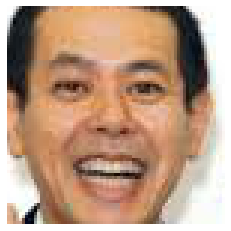

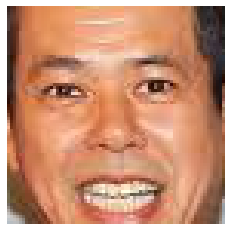

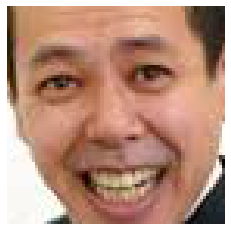

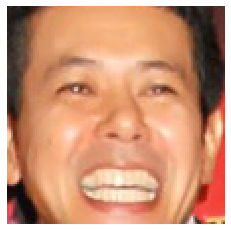

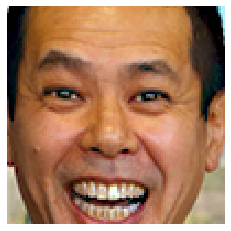

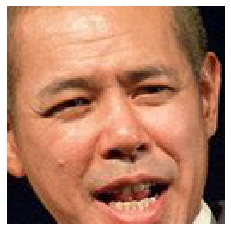

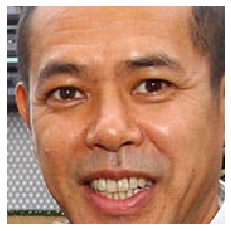

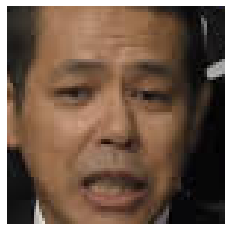

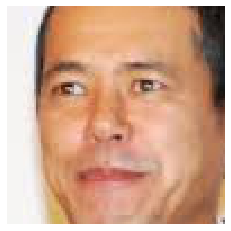

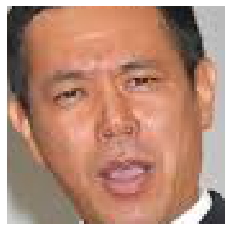

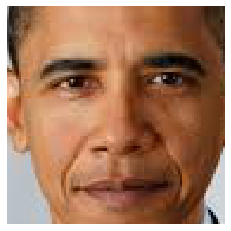

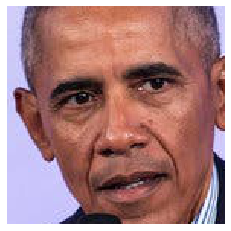

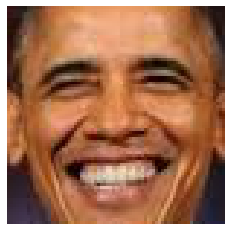

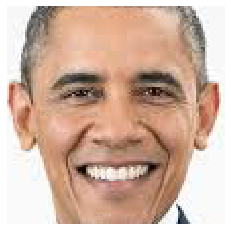

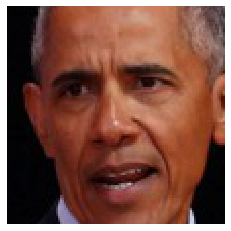

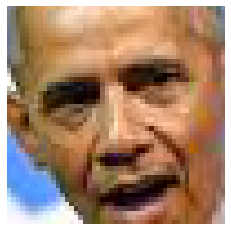

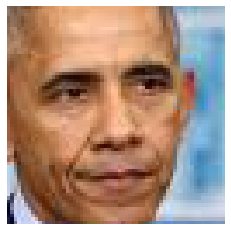

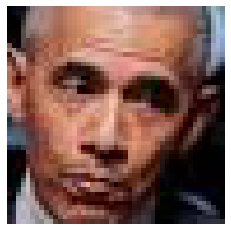

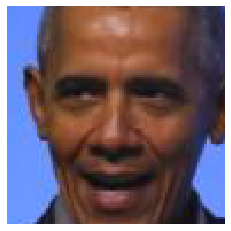

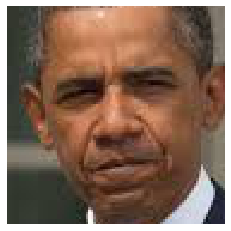

In [52]:
# Step1. 
# detect faces in each image and crop sample faces and stack them in A

trained_file = data.lbp_frontal_face_cascade_filename()
detector = Cascade(trained_file)

counter = 0

# get fake obama samples
for i in fobama_images:
    detected = detector.detect_multi_scale(img = i,
                                           scale_factor = 1.2,
                                           step_ratio = 1.5,
                                           min_size = (10,10),
                                           max_size = (200,200))
    show_image(getFace(i, detected[-1]))
    
    f = resize(getFace(i, detected[-1]), (m,n))
    f = color.rgb2gray(f)
    avg_f += f.reshape(-1,)
    A[counter] = f.reshape(-1,)
    
    counter += 1
    
# get real obama samples
for i in obama_images:
    detected = detector.detect_multi_scale(img = i,
                                           scale_factor = 1.2,
                                           step_ratio = 1.3,
                                           min_size = (10,10),
                                           max_size = (200,200))
    
    show_image(getFace(i, detected[-1]))

    f = resize(getFace(i, detected[-1]), (m,n))
    f = color.rgb2gray(f)
    avg_f += f.reshape(-1,)
    A[counter] = f.reshape(-1,)
    
    counter += 1

avg_f = avg_f/counter

In [53]:
# Step2.
# create variance space
var_f = np.zeros(m*n)

for i in A:
    var_f += (i - avg_f)*(i - avg_f)
    
var_f = var_f/counter

In [54]:
# Step3.
# center the sample pictures at the origin and standardize the contrast
for i in range(2*N):
    A[i] = (A[i]-avg_f)/var_f
    #show_image(A[i].reshape(m,n))

In [55]:
# Step4.
# compute the SVD
u, s, vh = np.linalg.svd(A.T, full_matrices=False)

In [57]:
# Step5.
# project each image onto basis
FOBM = np.empty((N,3))
OBM = np.empty((N,3))

for i in range(N):
    imvec = A[i]
    FOBM[i] = np.dot(u.T[:3] , A[i].reshape(-1,1)).T

for i in range(N):
    imvec = A[i]
    OBM[i] = np.dot(u.T[:3] , A[N+i].reshape(-1,1)).T

FOBM_df = pd.DataFrame(FOBM, columns=['PCA 1','PCA 2','PCA 3'])
FOBM_df['status'] = 'Fake'
OBM_df = pd.DataFrame(OBM, columns=['PCA 1','PCA 2','PCA 3'])
OBM_df['status'] = 'Real'
df = FOBM_df.append(OBM_df)

fig = px.scatter_3d(df, x='PCA 1', y='PCA 2', z='PCA 3', color='status')
fig.show()

In [58]:
# Step6.
# prepare test images

fake_test = plt.imread('fake_obama_test.jpg')
real_test = plt.imread('obama_test.jpg')
test_list = [fake_test, real_test]

trained_file = data.lbp_frontal_face_cascade_filename()
detector = Cascade(trained_file)

for i in range(2):
    detected = detector.detect_multi_scale(img = test_list[i],
                                               scale_factor = 1.2,
                                               step_ratio = 1,
                                               min_size = (100,100),
                                               max_size = (500,500))

    f = resize(getFace(test_list[i], detected[-1]), (m,n))
    f = color.rgb2gray(f)
    test_list[i] = f

In [59]:
# Step7.
# add some unexpected pictures

for i in range(2):
    test_list[i] = (test_list[i].reshape(-1,)-avg_f)/var_f

fake = np.dot(u.T[:3] , test_list[0].reshape(-1,1)).T
real = np.dot(u.T[:3] , test_list[1].reshape(-1,1)).T

fig.add_trace(
    go.Scatter3d(x=[real[0,0]], y=[real[0,1]], z=[real[0,2]], mode='markers', 
                 marker=dict(
                     color = 'orange',
                     symbol='square'),
                 name='test real')
)


fig.add_trace(
    go.Scatter3d(x=[fake[0,0]], y=[fake[0,1]], z=[fake[0,2]], mode='markers', 
                 marker=dict(
                     color = 'green',
                     symbol='diamond'),
                 name='test fake')
)

fig.show()